In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from logger import logger
import pandas as pd
from common_functions import NPCL, common
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

npcl_obj = NPCL()
common_obj  = common()

### data ingestion

In [2]:
df = npcl_obj.data_ingestion_npcl(data_path=os.getenv("data_path"))
data = npcl_obj.data_cleaning_and_validation(df)
# common_obj.correlation_matrix(df=data)

data.set_index(['creation_time'],drop= True, inplace= True)
resample_df = data[['Load_kW']].resample(rule="h").mean()

### features additions (lags, timeseries, weather, holidays)

from_date:  2024-07-01 to_date:  2024-07-31


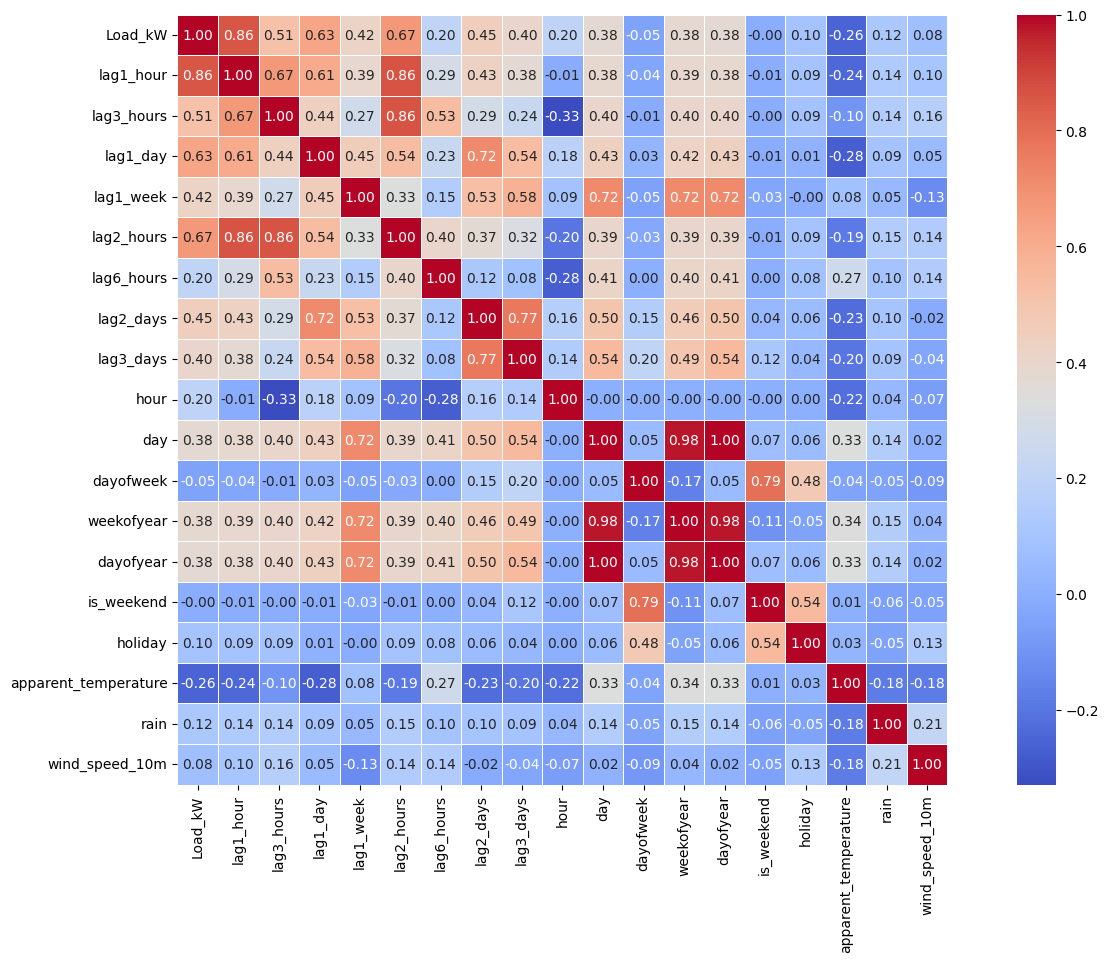

In [3]:

latitude, longitude = "28.625361","77.376214" #, 28.628059,77.378912

from_date = resample_df.first_valid_index().date()
to_date = resample_df.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date)
holidays_lst= common_obj.holidays_list(from_date,to_date)
# print("holidays_lst:",holidays_lst)

df_lags = common_obj.add_lags(resample_df,target_col="Load_kW")
df2 = common_obj.create_features(df_lags)
for date in holidays_lst:
    df2.loc[f"{date}", 'holiday'] = 1
df2.fillna(0,inplace= True)
df3 = df2.merge(weather_df,on=["creation_time"])
# df3.drop(['creation_time'],axis=1,inplace=True)
common_obj.correlation_matrix(df3)

# pca
# pca_df ,pca_result = common_obj.pca_function(df3)
# common_obj.pca_plot(pca_result)


### data split and training

# with all features


Model Power Evaluation
Mean Squared Error (MSE): 0.0026318239692688897
Mean Absolute Error (MAE): 0.03854995811730962
R-squared: 0.9081080288384863


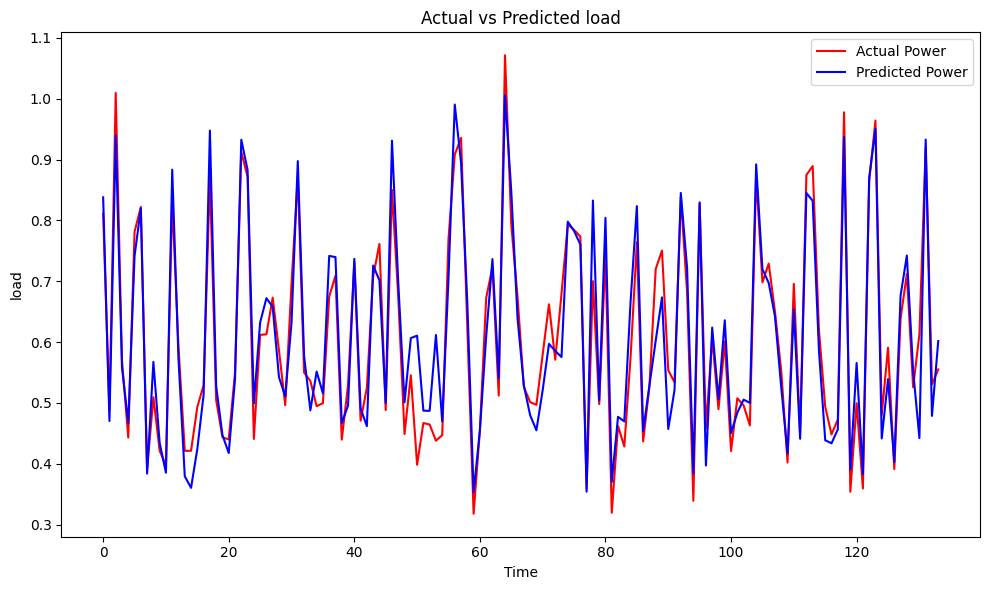


Model Power Evaluation
Mean Squared Error (MSE): 0.0195528277448701
Mean Absolute Error (MAE): 0.08859478095861921
R-squared: 0.5928016490957262


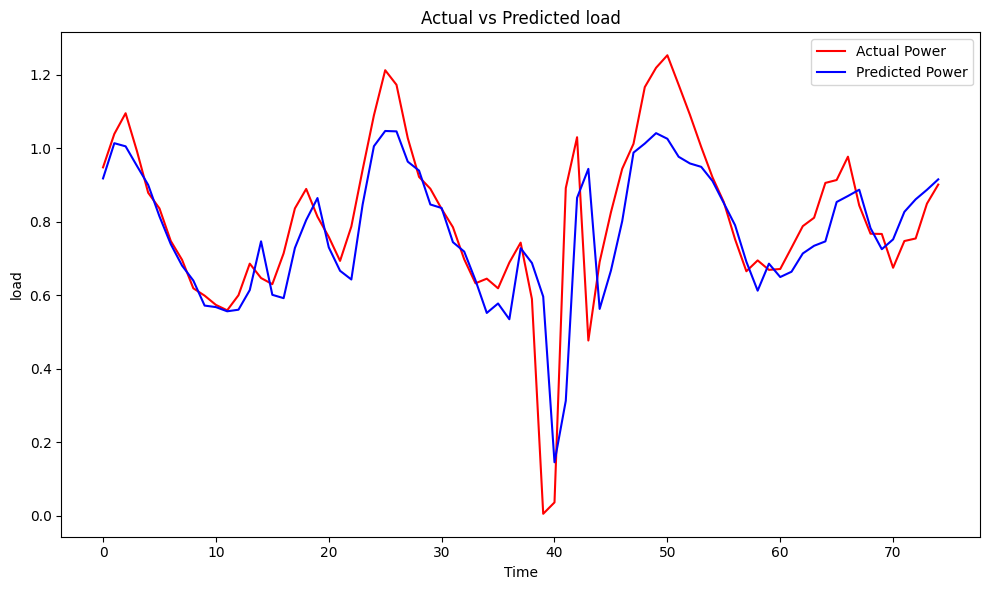

In [4]:
train_dataset,test_dataset = common_obj.data_split_function(df3, target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(train_dataset, target_variable= "Load_kW", model_name="RFR")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)




Model Power Evaluation
Mean Squared Error (MSE): 0.0018498463076514267
Mean Absolute Error (MAE): 0.033840869247887324
R-squared: 0.8955463993170265


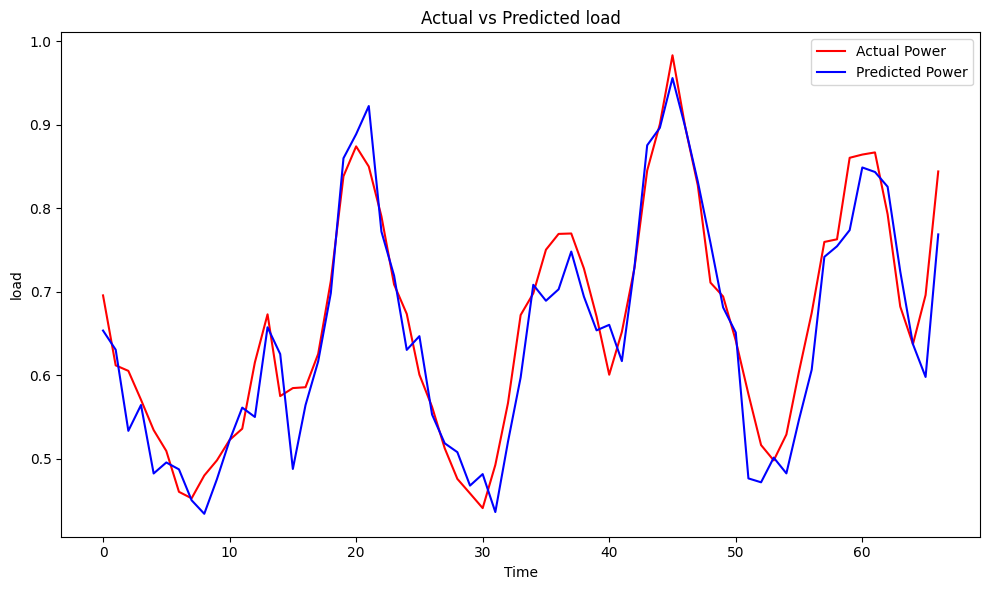


Model Power Evaluation
Mean Squared Error (MSE): 0.01945221943014582
Mean Absolute Error (MAE): 0.08900747778311568
R-squared: 0.594896872373788


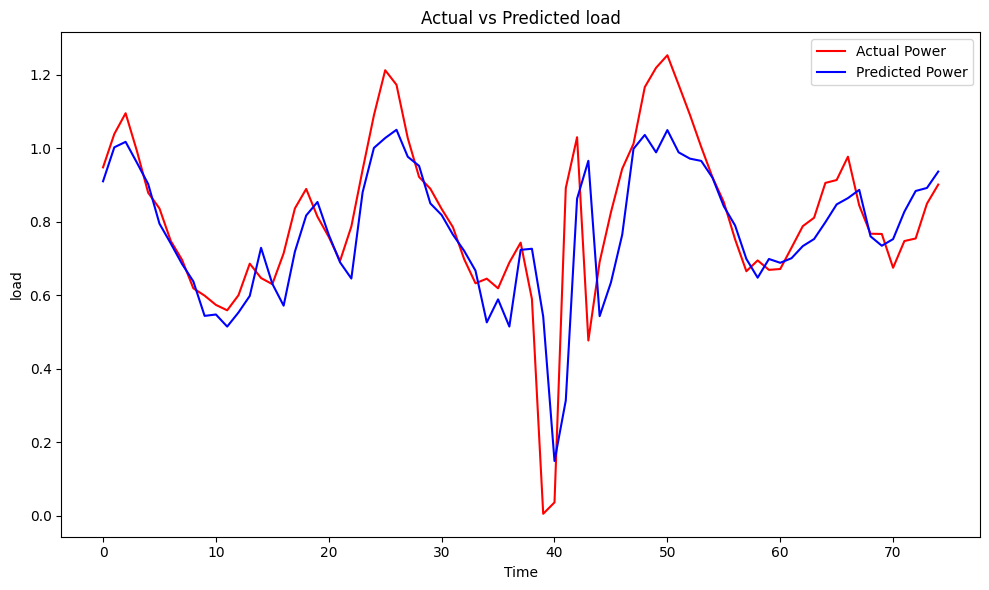

In [4]:
train_dataset,test_dataset = common_obj.data_split_function(df3, target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(train_dataset, target_variable= "Load_kW", model_name="RFR")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)



### removing features on basis of correlation

In [9]:
df3.columns

Index(['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend', 'holiday',
       'apparent_temperature', 'rain', 'wind_speed_10m'],
      dtype='object')

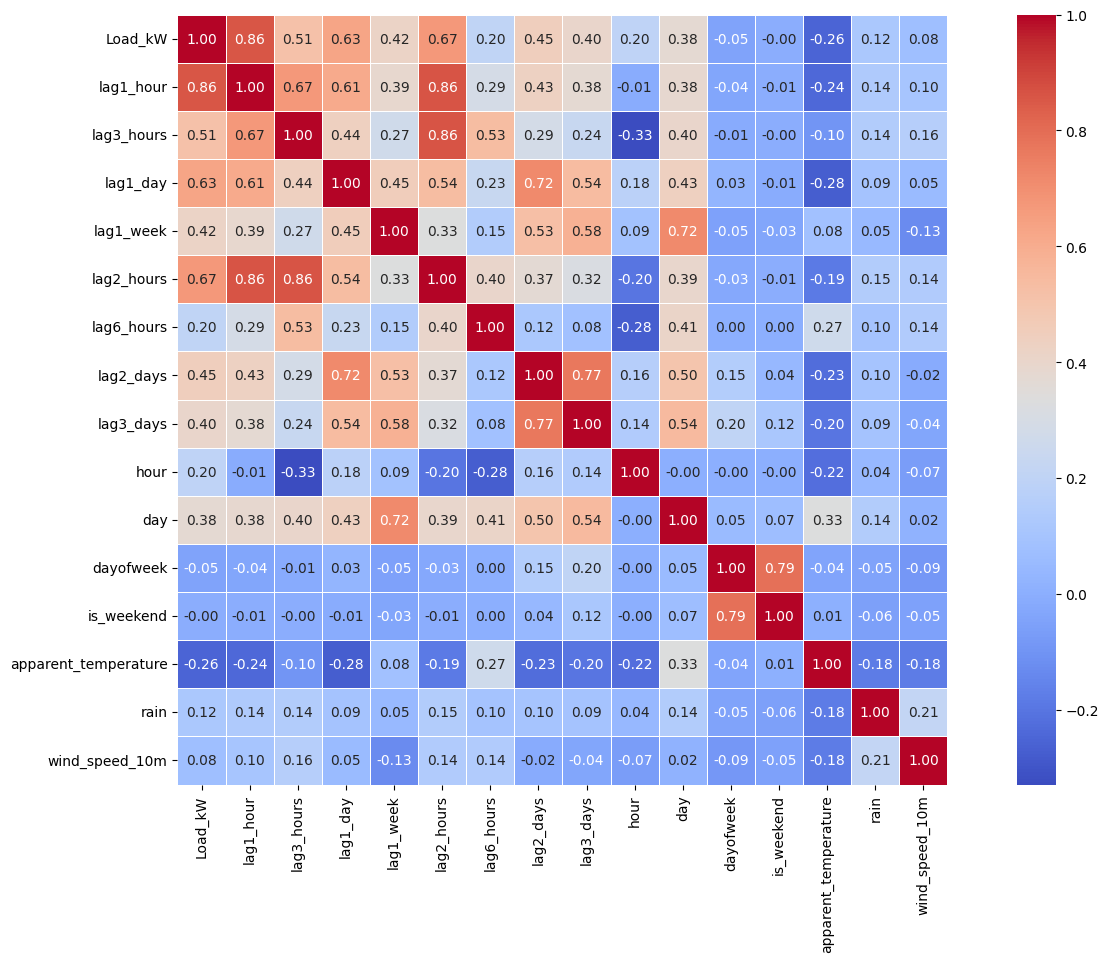

In [4]:
common_obj.correlation_matrix(df3[['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m']])


### with random data in training

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_jobs': -1, 'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}

Model Power Evaluation
Mean Squared Error (MSE): 0.002308734121439747
Mean Absolute Error (MAE): 0.037307856235332545
R-squared: 0.9193889364242399
Root Mean Squared Error (RMSE): 0.048049288459245124


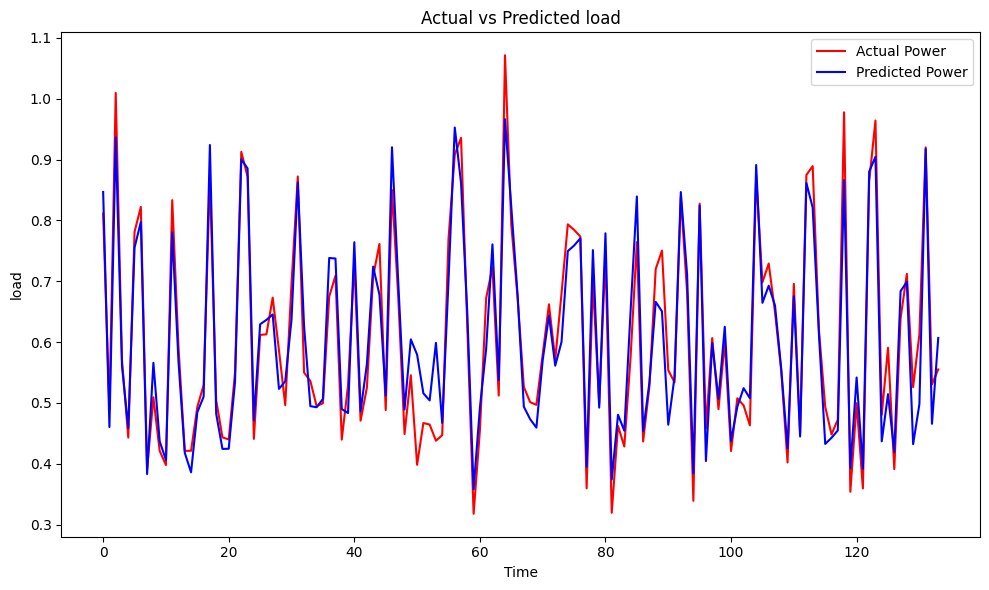


Model Power Evaluation
Mean Squared Error (MSE): 0.021736083581927912
Mean Absolute Error (MAE): 0.1058415456800249
R-squared: 0.5473341500693865
Root Mean Squared Error (RMSE): 0.14743162341210217


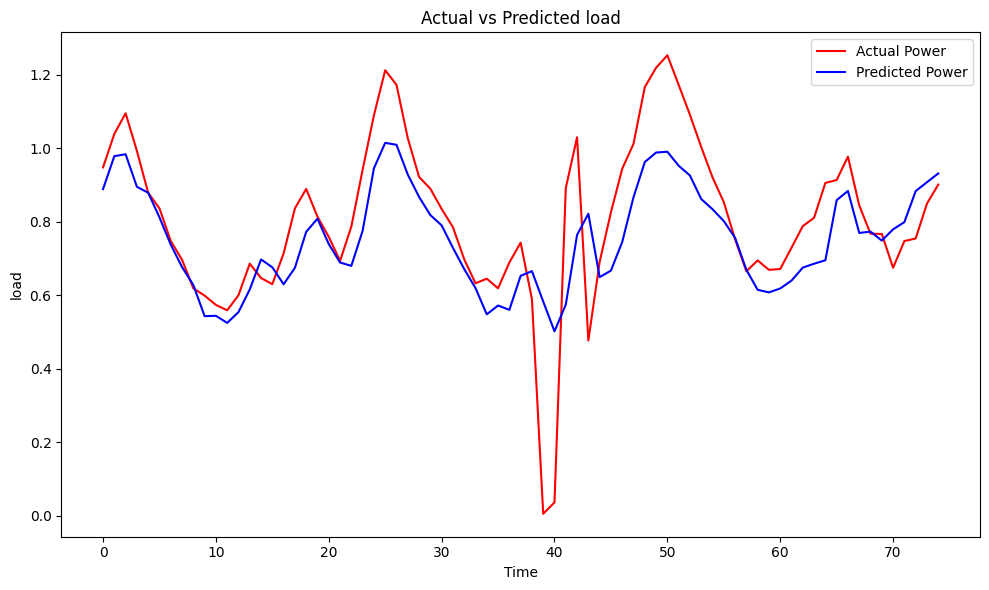

In [7]:
train_dataset,test_dataset = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(train_dataset, target_variable= "Load_kW",random_state=True, model_name="RFR")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)



### with data in sequence training

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_jobs': -1, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

Model Power Evaluation
Mean Squared Error (MSE): 0.0029137457746493006
Mean Absolute Error (MAE): 0.04325220974050916
R-squared: 0.8354721490223018
Root Mean Squared Error (RMSE): 0.05397912350760524


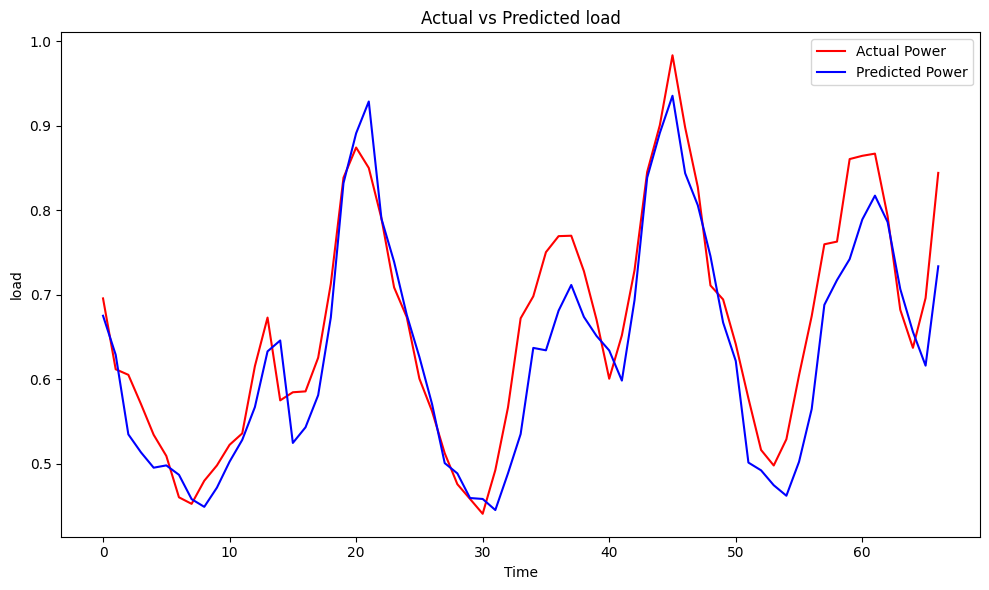


Model Power Evaluation
Mean Squared Error (MSE): 0.02336136042975876
Mean Absolute Error (MAE): 0.10916027143892516
R-squared: 0.5134868692138972
Root Mean Squared Error (RMSE): 0.1528442358408022


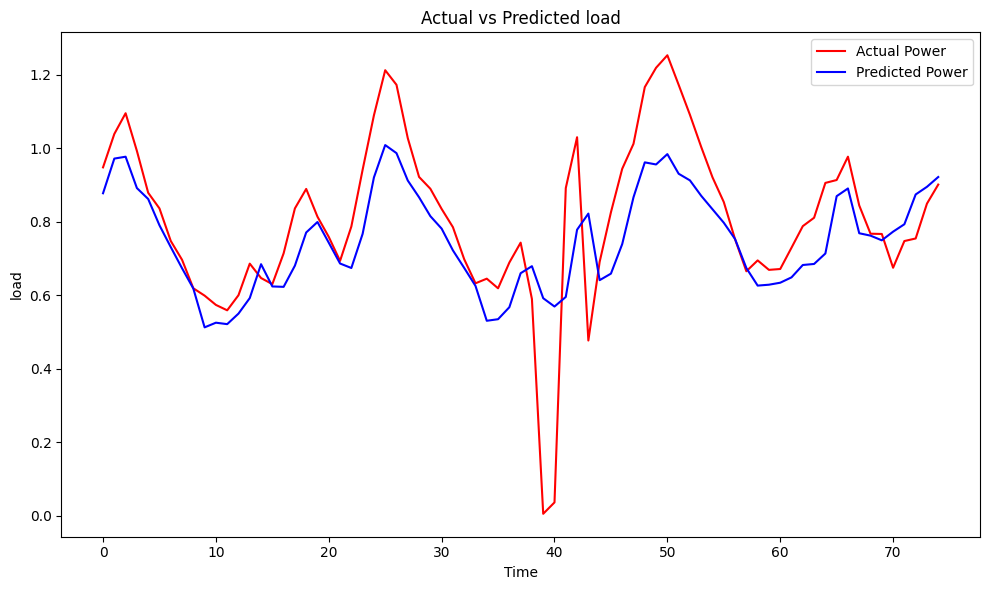

In [8]:
train_dataset,test_dataset = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(train_dataset, target_variable= "Load_kW",random_state=False, model_name="RFR")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)



Initial Train Score 0.9999643624024387
Best Parameters: {'subsample': 0.6, 'reg_alpha': 0.01, 'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.2}
TRAIN SCORE with hyperparameters tunning: 0.9280991277006388

Model Power Evaluation
Mean Squared Error (MSE): 0.002831214462108701
Mean Absolute Error (MAE): 0.03931235090443782
R-squared: 0.9011461705866194
Root Mean Squared Error (RMSE): 0.053209157690276405


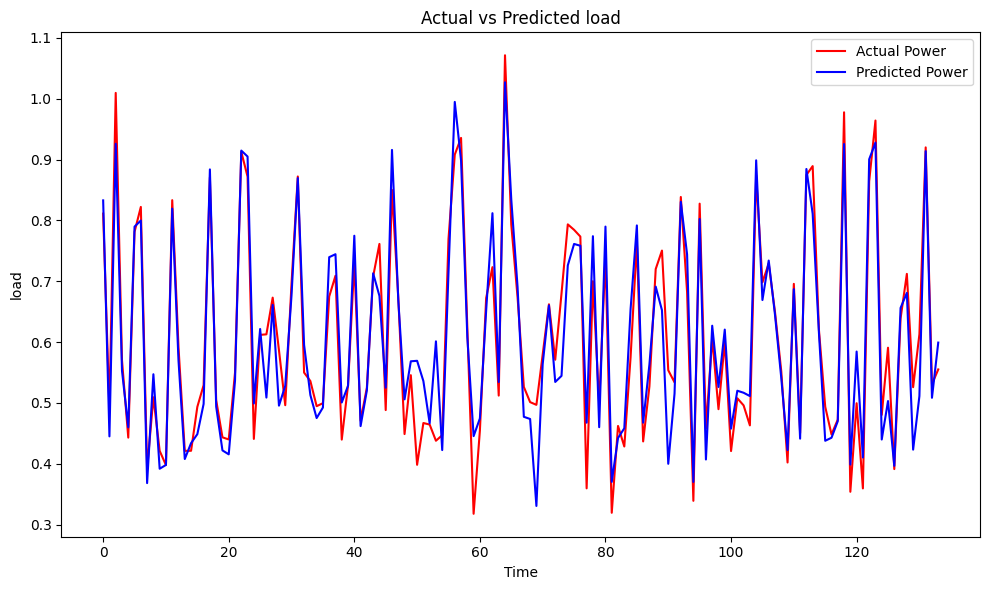


Model Power Evaluation
Mean Squared Error (MSE): 0.019549757127918437
Mean Absolute Error (MAE): 0.0942164587069565
R-squared: 0.5928655963761549
Root Mean Squared Error (RMSE): 0.1398204460296077


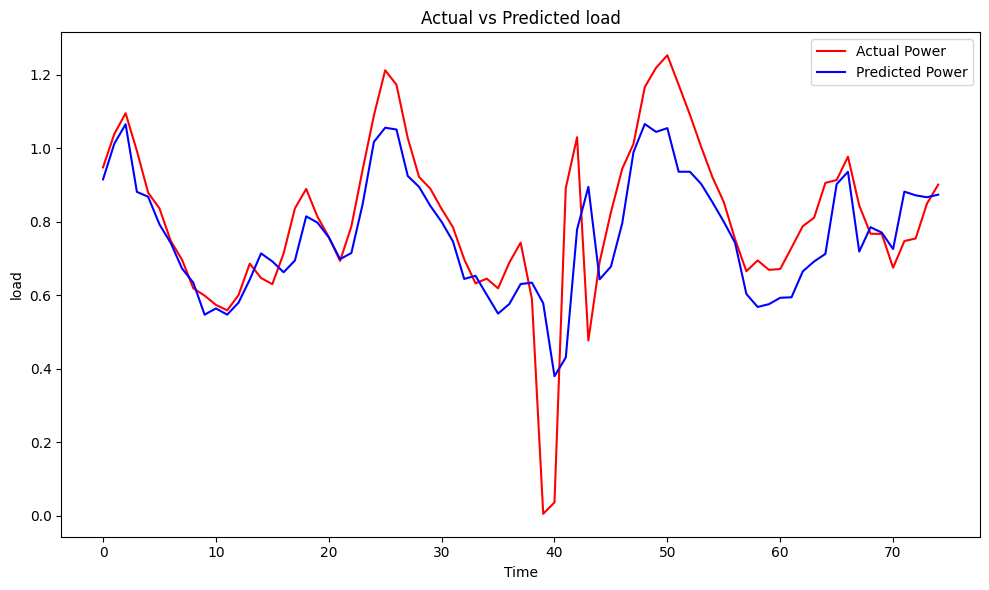

In [9]:
train_dataset,test_dataset = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(train_dataset, target_variable= "Load_kW", model_name="XGboost")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)



Initial Train Score 0.999957868645124
Best Parameters: {'subsample': 0.6, 'reg_alpha': 0.01, 'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.2}
TRAIN SCORE with hyperparameters tunning: 0.9305364298045031

Model Power Evaluation
Mean Squared Error (MSE): 0.0031266205686046396
Mean Absolute Error (MAE): 0.04244526740341621
R-squared: 0.8234519402993882
Root Mean Squared Error (RMSE): 0.05591619236504431


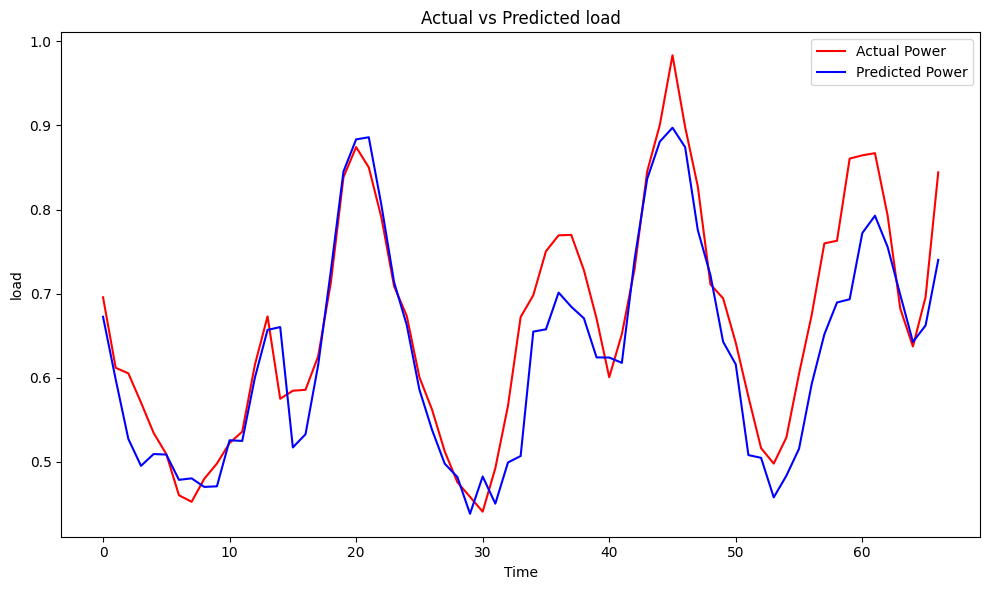


Model Power Evaluation
Mean Squared Error (MSE): 0.024481294630064904
Mean Absolute Error (MAE): 0.12397379897449883
R-squared: 0.49016362587352647
Root Mean Squared Error (RMSE): 0.15646499490322077


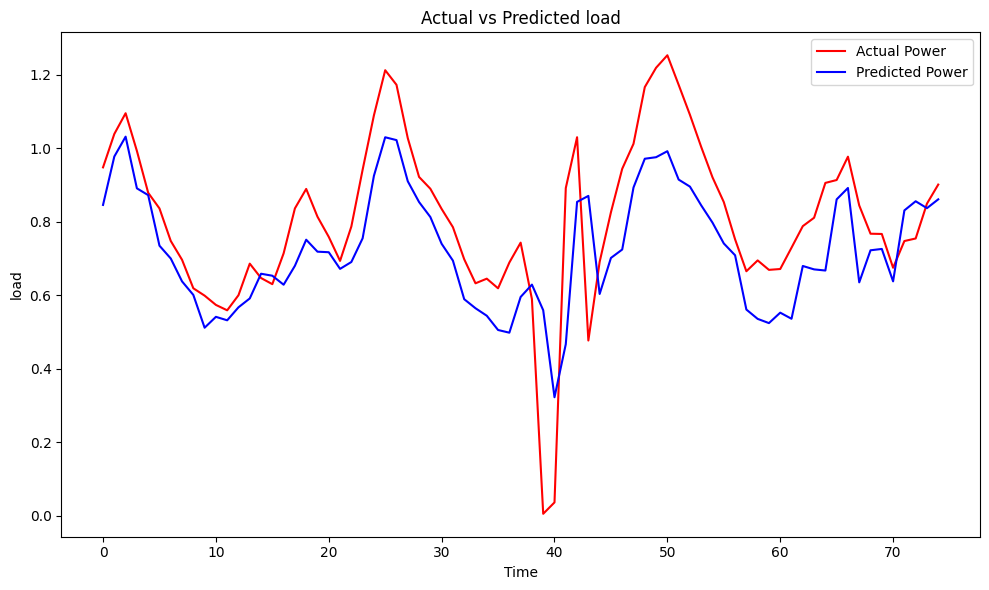

In [10]:
train_dataset,test_dataset = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(train_dataset, target_variable= "Load_kW",random_state=False ,model_name="XGboost")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)



Train Score 0.9999638642214591
Best Parameters: {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
TRAIN SCORE with hyperparameters tunning: 0.9421900569313846

Model Power Evaluation
Mean Squared Error (MSE): 0.0035101146508863933
Mean Absolute Error (MAE): 0.04910826545900238
R-squared: 0.8017975263249653


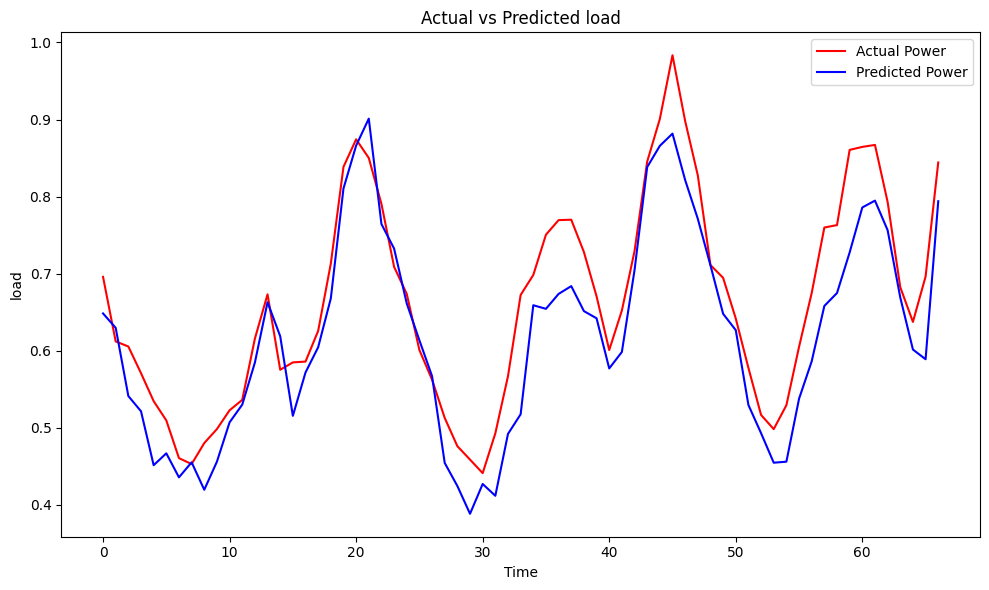


Model Power Evaluation
Mean Squared Error (MSE): 0.033316680629920464
Mean Absolute Error (MAE): 0.14637473414841246
R-squared: 0.30616187146295004


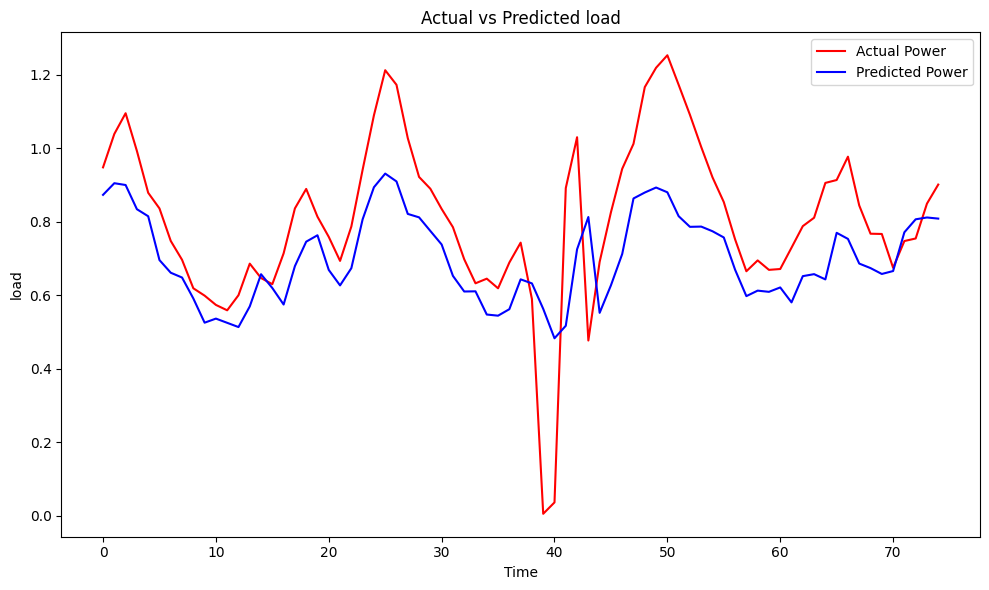

In [8]:
train_dataset,test_dataset = common_obj.data_split_function(df3, target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(train_dataset, target_variable= "Load_kW", model_name="XGboost")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)



In [11]:
train_dataset,test_dataset = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_label = train_features.pop("Load_kW")
test_label = test_features.pop("Load_kW")

from sklearn.ensemble import RandomForestRegressor
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_features, train_label)

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Base model (weak learner)
base_model = DecisionTreeRegressor(max_depth=3)
# Initialize and train AdaBoost
model = AdaBoostRegressor(base_estimator=base_model, n_estimators=50, random_state=42)
model.fit(train_features, train_label)

from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(train_features, train_label)


from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]

# Define the meta model
meta_model = LinearRegression()

# Initialize and train Stacking Regressor
model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
model.fit(train_features, train_label)

from sklearn.ensemble import VotingRegressor

# Define the individual models
model1 = RandomForestRegressor(n_estimators=100, random_state=42)
model2 = XGBRegressor(n_estimators=100, random_state=42)
model3 = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Create a Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('rf', model1),
    ('xgb', model2),
    ('gb', model3)
])

# Train the voting model
voting_model.fit(train_features, train_label)



TypeError: __init__() got an unexpected keyword argument 'base_estimator'

In [ ]:
train_dataset,test_dataset = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")
# X_train = common_obj.scaling_layer(X_train)

def train_arima(train_data, order=(5, 1, 0)):
    model = ARIMA(train_data, order=order)
    arima_model = model.fit()
    print(arima_model.summary())
    return arima_model

model= common_obj.model_trainer(train_dataset, target_variable= "Load_kW", model_name="XGboost")
test_label = test_dataset.pop("Load_kW")
pred = common_obj.prediction(model, test_dataset, scoring=True, test_data=test_label,prediction=True)



In [ ]:

# Assume 'Load_kW' is the target variable, and the dataset is indexed by time
def train_arima(train_data, order=(5, 1, 0)):
    model = ARIMA(train_data, order=order)
    arima_model = model.fit()
    print(arima_model.summary())
    return arima_model

def train_sarima(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    sarima_model = model.fit()
    print(sarima_model.summary())
    return sarima_model

# Example for predictions and evaluation
def evaluate_model(model, test_data):
    predictions = model.forecast(steps=len(test_data))
    mse = mean_squared_error(test_data, predictions)
    print(f'MSE: {mse}')
    
    # Plot
    plt.plot(test_data.index, test_data, label='Actual')
    plt.plot(test_data.index, predictions, label='Predicted')
    plt.legend()
    plt.show()
train_dataset,test_dataset
# Train ARIMA
train_dataset,test_dataset = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag3_hours', 'lag1_day', 'lag1_week',
       'lag2_hours', 'lag6_hours', 'lag2_days', 'lag3_days', 'hour', 'day',
       'dayofweek', 'is_weekend',
       'apparent_temperature', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")

arima_model = train_arima(train_data)
evaluate_model(arima_model, test_data)

# Train SARIMA
sarima_model = train_sarima(train_data)
evaluate_model(sarima_model, test_data)


### without weather data


Model Power Evaluation
Mean Squared Error (MSE): 0.0024744984675106486
Mean Absolute Error (MAE): 0.037160881893582715
R-squared: 0.860274729988708


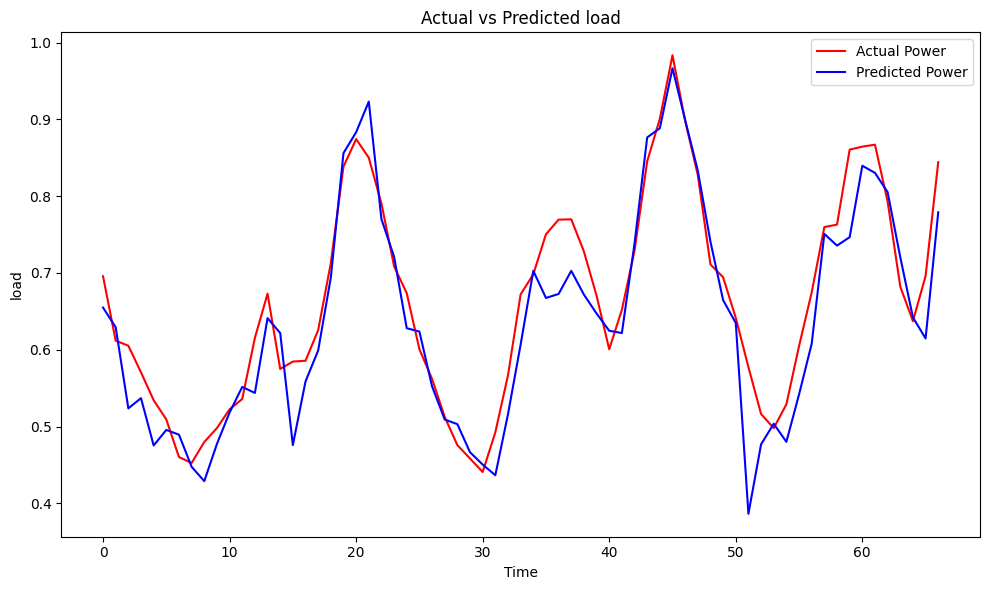


Model Power Evaluation
Mean Squared Error (MSE): 0.02471784581294776
Mean Absolute Error (MAE): 0.12638239064574636
R-squared: 0.48523731788210944


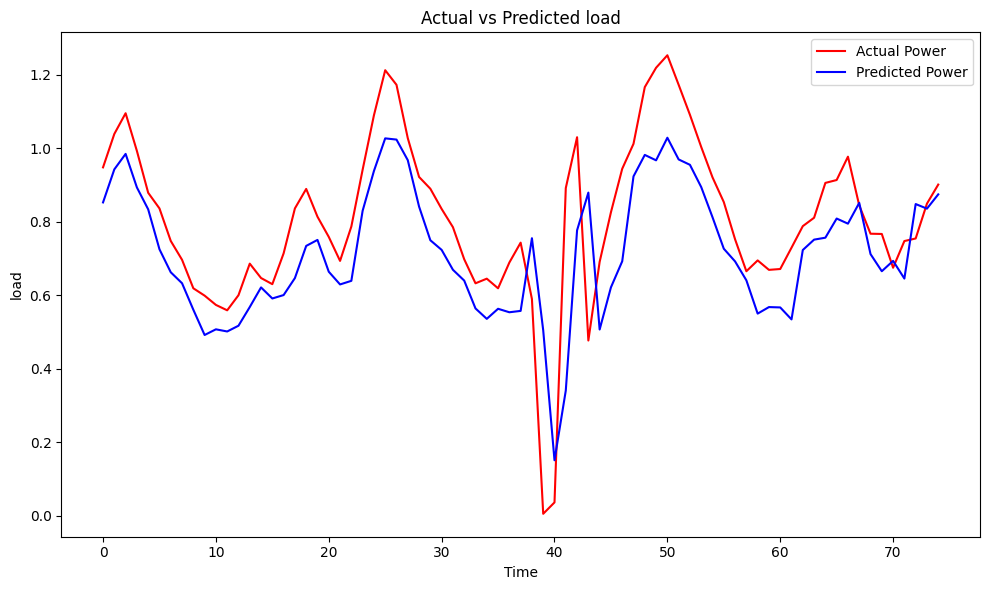

In [7]:

X_train, X_test, y_train, y_test = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours',
       'lag12_hours', 'lag1_day', 'lag1_week', 'lag2_days', 'lag3_days',
       'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend']
], target_variable= "Load_kW")
X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(X_train,y_train,model_name="RFR")
pred = common_obj.prediction(model,X_test,scoring=True,test_data=y_test,prediction=True)



### lags and weather both


Model Power Evaluation
Mean Squared Error (MSE): 0.0030256639372329528
Mean Absolute Error (MAE): 0.04083123952209969
R-squared: 0.8291525672195698


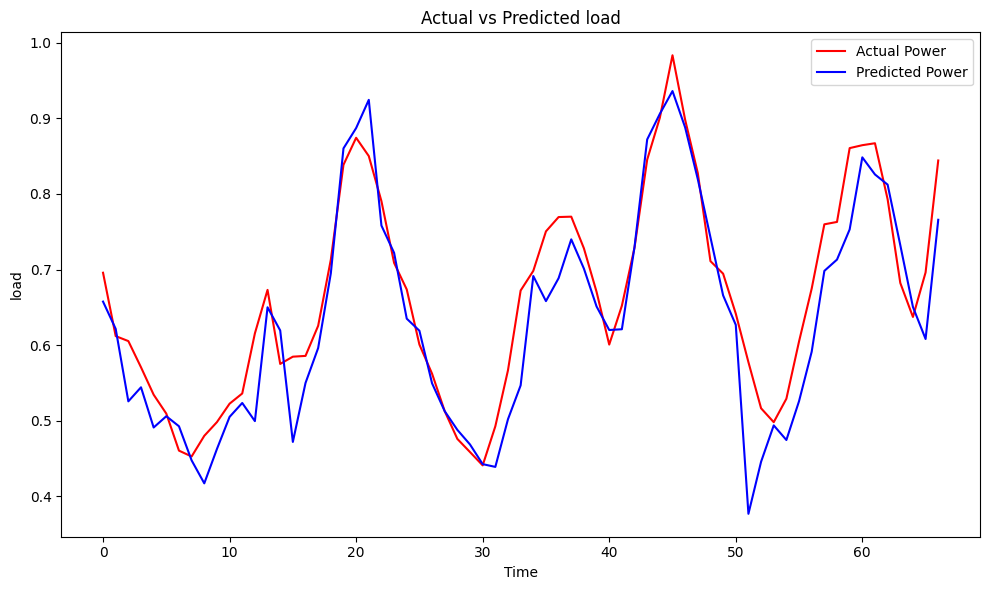


Model Power Evaluation
Mean Squared Error (MSE): 0.024179712048322158
Mean Absolute Error (MAE): 0.1269465851671275
R-squared: 0.4964442483773134


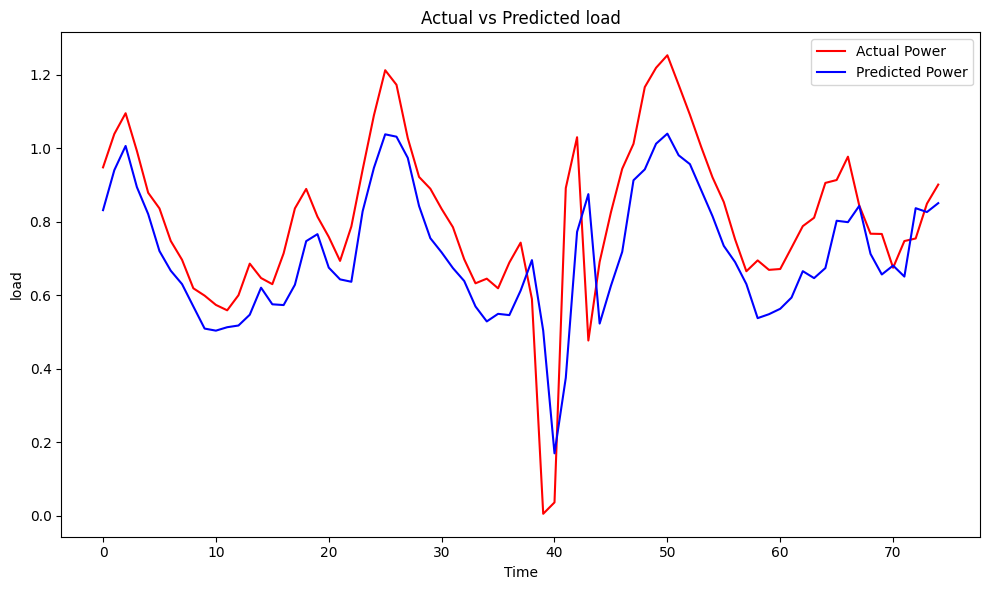

In [8]:

X_train, X_test, y_train, y_test = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 
        'lag1_day','lag3_days',
       'hour', 'day', 'dayofweek', 'dayofyear', 'is_weekend']
], target_variable= "Load_kW")
X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(X_train,y_train,model_name="RFR")
pred = common_obj.prediction(model,X_test,scoring=True,test_data=y_test,prediction=True)



In [9]:
df3.columns

Index(['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours',
       'lag12_hours', 'lag1_day', 'lag1_week', 'lag2_days', 'lag3_days',
       'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend',
       'holiday', 'temperature_2m', 'relative_humidity_2m',
       'apparent_temperature', 'precipitation', 'rain', 'wind_speed_10m',
       'wind_speed_100m'],
      dtype='object')


Model Power Evaluation
Mean Squared Error (MSE): 0.002187878545068549
Mean Absolute Error (MAE): 0.03510811139939865
R-squared: 0.8764590382756824


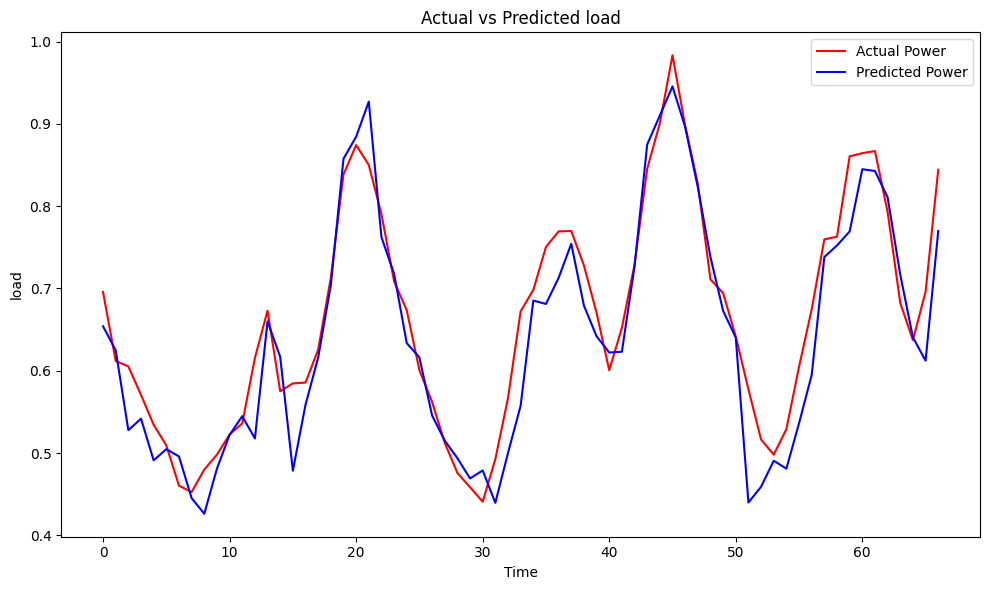


Model Power Evaluation
Mean Squared Error (MSE): 0.025292996873489664
Mean Absolute Error (MAE): 0.13118528086758885
R-squared: 0.47325948191743916


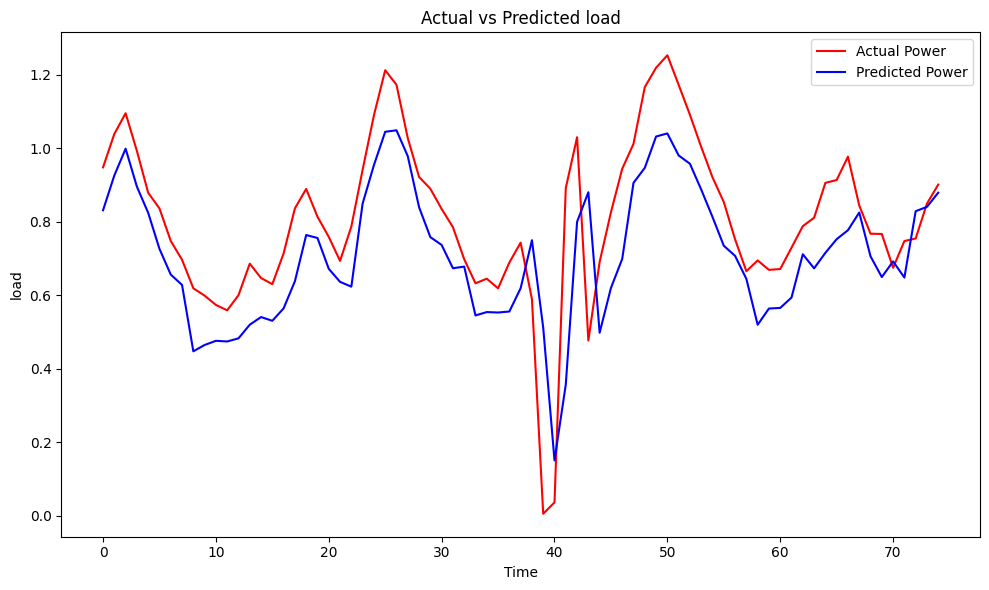

In [10]:

X_train, X_test, y_train, y_test = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours','lag1_day','lag3_days','hour', 'day', 'dayofweek', 'dayofyear', 'is_weekend','temperature_2m', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")
X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(X_train,y_train,model_name="RFR")
pred = common_obj.prediction(model,X_test,scoring=True,test_data=y_test,prediction=True)

